## Experiment 2
**Definition**

In [1]:
import sys
import numpy as np
from pathlib import Path
from statistics import mean
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT)) 
if str(ROOT / 'track') not in sys.path:
    sys.path.append(str(ROOT / 'track')) 
if str(ROOT / 'track' / 'yolov5') not in sys.path:
    sys.path.append(str(ROOT / 'track' / 'yolov5'))
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1
from recognition.embedding import EmbeddingPool
from recognition.dataset import TrainingSetLabeled, TrainingSetUnlabeled
from recognition.train import get_device, get_cosine_schedule_with_warmup, evaluate_accuracy
%matplotlib inline

In [5]:
def train_SSL(model, labeled_trainloader, unlabeled_trainloader, testset_path, unseenface_folder, num_classes, num_epochs, num_iters, learning_rate, threshold=0.95):
    '''
    train_SSL:
        train the face recognition network using semi-supervised learning and triplet loss 
    inputs:
        model                 - face recognition model to be trained
        labeled_trainloader   - dataloader for the small labeled training set
        unlabeled_trainloader - dataloader for the unlabeled training set
        testset_path          - path to the testst
        unseenface_folder     - path to unseen face folder
        num_epochs            - number of training epochs for semi-supervised learning and triplet-loss learning
        num_iters             - number of batches to be run for each epoch with batch_size = 8
        learning_rate         - learning rate
        threshold             - threshold value for generating pseudo labels
    output: 
        accuracy_list         - list of accuracy after each training epoch (len=2*num_epochs)
    '''
    accuracy_list = []
    # params_1x: parameters with 1x learning rates
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate},
        {'params': model.logits.parameters(), 'lr': learning_rate*180}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    labeled_iter = iter(labeled_trainloader)
    unlabeled_iter = iter(unlabeled_trainloader)
    
    device = get_device()
    model.train()
    for epoch in range(num_epochs):
        for batch_idx in range(num_iters):
            # obtain the labeled batch
            try:
                inputs_x, targets_x = next(labeled_iter)
            except:
                labeled_iter = iter(labeled_trainloader)
                inputs_x, targets_x = next(labeled_iter)
            
            # obtain te unlabeled batch
            try:
                inputs_u, inputs_u_w = next(unlabeled_iter)
            except:
                unlabeled_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u_w = next(unlabeled_iter)
                
            num_x = inputs_x.shape[0] # number of labeled images in a batch
            num_u = inputs_u.shape[0] # number of unlabeled imaegs in a batch
            
            # obtain the outputs of the model
            inputs = torch.cat((inputs_x, inputs_u, inputs_u_w)).to(device)
            targets_x = targets_x.to(device)
            logits = model(inputs)
            
            # extract the logits
            logits_x = logits[:num_x]
            logits_u, logits_u_w = logits[num_x:].chunk(2)
            assert logits_u.shape[0] == num_u and logits_u_w.shape[0] == num_u
            del logits
            
            # Supervised loss
            Lx = F.cross_entropy(logits_x, targets_x, reduction='mean')
            
            # Semi-supervised loss
            pseudo_label = torch.softmax(logits_u.detach(), dim=-1)
            max_probs, targets_u = torch.max(pseudo_label, dim=-1)
            mask = max_probs.ge(threshold).float()
            
            total_sum = mask.sum().item()
            
            if total_sum > 0.5: 
                Lu = (F.cross_entropy(logits_u_w, targets_u, reduction='none')*mask).sum() / total_sum

            else:
                Lu = 0
            
            # total loss
            lambda_u = 1.0 
            loss = Lx + lambda_u * Lu            
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
    
    order = 1 # distance order
    model.eval()
    model.classify = False
    ep = EmbeddingPool(labeled_trainloader, model, get_device())
    before_triplet_seen = [[] for _ in range(num_classes)]
    before_triplet_unseen = [[] for _ in range(num_classes)]
    unseenset = TrainingSetLabeled(unseenface_folder, transform=False)
    for i in range(num_classes):
        testset = TrainingSetLabeled(testset_path, transform=False, class_idx=i)
        for j in range(min(len(testset), len(unseenset))):
            x0 = testset[j][0].to(get_device()).unsqueeze(0)
            x1 = unseenset[j][0].to(get_device()).unsqueeze(0)
            with torch.no_grad():
                e0 = model(x0)
                e1 = model(x1)
            before_triplet_seen[i].append(ep.get_min_dist(e0)**order)
            before_triplet_unseen[i].append(ep.get_min_dist(e1)**order)
    
    
    # Triplet Loss Fine-tune
    print("Start Triplet Fine-Tuning......")
    model.classify = False
    params_1x = [param for name, param in model.named_parameters() if name not in ["logits.weight", "logits.bias"]]
    grouped_parameters = [
        {'params': params_1x, 'lr': learning_rate*20},
        {'params': model.logits.parameters(), 'lr': 0}
    ]
    optimizer = torch.optim.SGD(grouped_parameters, lr=learning_rate, weight_decay=0.001)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_epochs*num_iters)
    
    triplet_loss = TripletMarginLoss(margin=1, p=2)
    device = get_device()
    model.classify = False
    model.eval()
    for epoch in range(num_epochs):
        labeled_iter = iter(labeled_trainloader)
        all_embeddings = None
        all_ys = None
        for X, y in labeled_iter:
            X = X.to(device)
            embedding = model(X)
            if all_embeddings is None:
                all_embeddings = embedding
                all_ys = y
            else:
                all_embeddings = torch.cat((all_embeddings, embedding))
                all_ys = torch.cat((all_ys, y))
        # Form the triplets: (anchor, positive, hard negative)
        anchor, positive, negative = None, None, None
        for idx, (e, y) in enumerate(zip(all_embeddings, all_ys)):
            min_neg_dist, min_neg = 999999, None
            pair_counter = 0
            for idx1, (e1, y1) in enumerate(zip(all_embeddings, all_ys)):
                if idx == idx1:
                    continue
                # Include all anchor-positive pairs
                if y == y1:
                    pair_counter += 1
                    if anchor is None:
                        anchor, positive = e.unsqueeze(0), e1.unsqueeze(0)
                    else:
                        anchor, positive = torch.cat((anchor, e.unsqueeze(0))), torch.cat((positive, e1.unsqueeze(0)))
                else:
                    curr_dist = (e-e1).norm().item()
                    if curr_dist < min_neg_dist:
                        min_neg_dist = curr_dist
                        min_neg = e1
            if negative is None:
                negative = torch.cat(tuple([min_neg.unsqueeze(0) for _ in range(pair_counter)]))
            else:
                negative = torch.cat((negative, torch.cat(tuple([min_neg.unsqueeze(0) for _ in range(pair_counter)]))))
        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        
    
    order = 1 # distance order
    model.eval()
    model.classify = False
    ep = EmbeddingPool(labeled_trainloader, model, get_device())
    after_triplet_seen = [[] for _ in range(num_classes)]
    after_triplet_unseen = [[] for _ in range(num_classes)]
    unseenset = TrainingSetLabeled(unseenface_folder, transform=False)
    for i in range(num_classes):
        testset = TrainingSetLabeled(testset_path, transform=False, class_idx=i)
        for j in range(min(len(testset), len(unseenset))):
            x0 = testset[j][0].to(get_device()).unsqueeze(0)
            x1 = unseenset[j][0].to(get_device()).unsqueeze(0)
            with torch.no_grad():
                e0 = model(x0)
                e1 = model(x1)
            after_triplet_seen[i].append(ep.get_min_dist(e0)**order)
            after_triplet_unseen[i].append(ep.get_min_dist(e1)**order)
    return before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen

In [6]:
def train(source, face_folder, test_folder, unseenface_folder):
    '''
    train():
        This function is used to tune the pretrained face recognition network using the semi-supervised learning + triplet loss
    inputs:
        source: path to the video source
        face_folder: path to the face labeled set
        test_folder: path to the face test set
    NOTE: All images in the training set are in the RGB format!
    '''
    # Load small labeled dataset provided by the user
    print("Loading the labeled dataset......")
    LabeledTrainSet = TrainingSetLabeled(face_folder)
    LabeledTrainLoader = DataLoader(LabeledTrainSet, batch_size=8, shuffle=True)
    # Load unlabeled dataset obtained from the video
    print("Loading the unlabeled dataset......")
    UnlabeledTrainSet = TrainingSetUnlabeled(source, "data", num_images=2048)
    UnlabeledTrainLoader = DataLoader(UnlabeledTrainSet, batch_size=8*10, shuffle=True)
    # Load large labeled testset
    print("Loading the labeled testset......")
    LabeledTestSet = TrainingSetLabeled(test_folder, transform=False)
    LabeledTestLoader = DataLoader(LabeledTestSet, batch_size=8, shuffle=False)
    # Get the number of characters of interest
    num_classes = LabeledTrainSet.get_num_classes()
    # Load pretrained face recognition network
    fr_model = InceptionResnetV1(
        classify=True,
        pretrained='vggface2',
        num_classes=num_classes
    ).to(get_device())
    # Initialize the weight-parameters of the classification 
    nn.init.xavier_uniform_(fr_model.logits.weight)
    # Tune the face recognition network using semi-supervised training + triplet loss
    print("Start training the recognition network......")
    before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen = train_SSL(fr_model, LabeledTrainLoader, UnlabeledTrainLoader, test_folder, unseenface_folder, num_classes, num_epochs=10, num_iters=40, learning_rate=1.5e-4, threshold=0.99)
    print("Finish training the recognition network......")
    return before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen

In [7]:
source = '../datasets/vct2/vct2.mp4'
face_folder = '../datasets/vct2/face/'
test_folder = '../datasets/vct2/test/'
unseen_folder = '../datasets/vct2/unseen/'

In [62]:
before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen = train(source, face_folder, test_folder, unseen_folder)

Loading the labeled dataset......
Loading the unlabeled dataset......
Loading the labeled testset......
Start training the recognition network......
Start Triplet Fine-Tuning......
Finish training the recognition network......


In [63]:
def distance_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen):
    num_figs = len(before_triplet_seen)
    fig = plt.figure(figsize=(6*num_figs, 6))
    for i in range(num_figs):
        ax = fig.add_subplot(1, num_figs, i+1)
        plt.subplot(1, num_figs, i+1)
        plt.ylim(0.4, 1.8)
        plt.xlim(0, len(before_triplet_seen[i]))
        plt.xticks([])
        before_triplet_seen[i].sort()
        before_triplet_unseen[i].sort()
        after_triplet_seen[i].sort()
        after_triplet_unseen[i].sort()
        plt.scatter(range(len(before_triplet_seen[i])), before_triplet_seen[i], c='skyblue')
        plt.scatter(range(len(before_triplet_unseen[i])), before_triplet_unseen[i], c='violet')
        plt.scatter(range(len(after_triplet_seen[i])), after_triplet_seen[i], c='blue')
        plt.scatter(range(len(after_triplet_unseen[i])), after_triplet_unseen[i], c='m')
        plt.legend([f'face{i+1} - before triplet', 'unseen - before triplet', f'face{i+1} - after triplet', 'unseen - after triplet'])
        poly_coords = [(0, 0.4), (len(before_triplet_seen[i]), 0.4), (len(before_triplet_seen[i]), after_triplet_unseen[i][0]), (0, after_triplet_unseen[i][0])]
        ax.add_patch(plt.Polygon(poly_coords, color ='gray', alpha = 0.3)) 
        plt.ylabel("Embedding Distances")
    plt.show()

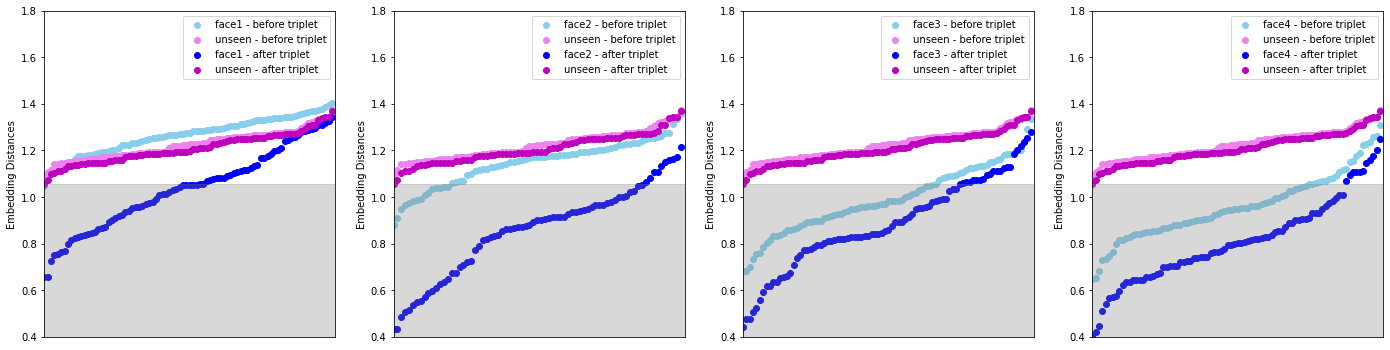

In [64]:
distance_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen)

In [77]:
def average_separation_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen):
    num_faces = len(before_triplet_seen)
    labels = [f'Face{i+1}' for i in range(num_faces)]
    before_separation = [mean(before_triplet_unseen[i]) - mean(before_triplet_seen[i]) for i in range(num_faces)]
    after_separation = [mean(after_triplet_unseen[i]) - mean(after_triplet_seen[i]) for i in range(num_faces)]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, before_separation, width, label='Before Triplet Loss', color='skyblue', alpha=0.7)
    rects2 = ax.bar(x + width/2, after_separation, width, label='After Triplet Loss', color='royalblue', alpha=0.7)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average Separation')
    ax.set_title('Average Separation Before & After Triplet Loss Training')
    ax.set_xticks(x, labels)
    ax.legend(loc='upper left')
    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')
    plt.ylim(-0.08, 0.5)
    
    fig.tight_layout()

    plt.show()

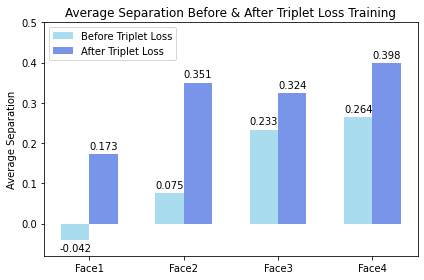

In [78]:
average_separation_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen)

In [79]:
def false_negative_rate_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen):
    num_faces = len(before_triplet_seen)
    labels = [f'Face{i+1}' for i in range(num_faces)]
    before_fnr = [0 for i in range(num_faces)]
    after_fnr = [0 for i in range(num_faces)]
    for i in range(num_faces):
        threshold_before = before_triplet_unseen[i][0]
        for j in range(len(before_triplet_seen[i])):
            if before_triplet_seen[i][j] > threshold_before:
                before_fnr[i] = (len(before_triplet_seen[i]) - j)/len(before_triplet_seen[i])
                break
        threshold_after = after_triplet_unseen[i][0]
        for j in range(len(after_triplet_seen[i])):
            if after_triplet_seen[i][j] > threshold_after:
                after_fnr[i] = (len(after_triplet_seen[i]) - j)/len(after_triplet_seen[i])
                break
    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, before_fnr, width, label='Before Triplet Loss', color='skyblue', alpha=0.7)
    rects2 = ax.bar(x + width/2, after_fnr, width, label='After Triplet Loss', color='royalblue', alpha=0.7)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('False Negative Rate')
    ax.set_title('False Negative Rate Before & After Triplet Loss Training')
    ax.set_xticks(x, labels)
    ax.legend()
    
    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')
    plt.ylim(0, 1.1)

    fig.tight_layout()

    plt.show()

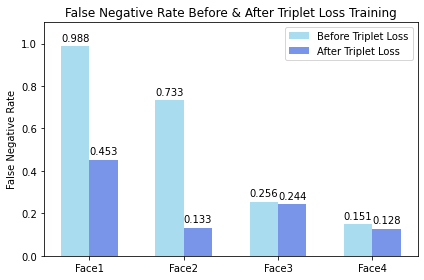

In [80]:
false_negative_rate_plot(before_triplet_seen, before_triplet_unseen, after_triplet_seen, after_triplet_unseen)